In [1]:
# regression (회귀)

# 회귀 : 가격이나 확률같이 연속된 출력 값을 예측하는 것이 목적
# 분류 : 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적 

In [ ]:
# 이 노트북은 Auto MPG 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다.
# 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 
# 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

In [2]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
!pip install -q seaborn

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [4]:
# 데이터 셋 다운로드
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 5us/step


'C:\\Users\\bsww201\\.keras\\datasets\\auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 

# 판다스(pd)를 사용해 데이터 읽기
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
# 이 데이터 셋은 일부 데이터가 누락되어있음
# 누락된 데이터 셋를 찾는 것 => isna()  : missing value를 찾아서 true를 반환

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
# 문제를 간단하게 만들기 위해 누락된 행을 삭제 

dataset = dataset.dropna()

In [8]:
# orign은 범주형(수치형X)이기 때문에 one-hot encoding으로 변환하기 

origin = dataset.pop('Origin')

In [9]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [10]:
# 데이터 셋을 training set와 test set으로 분할하기 
# test set은 모델을 최종적으로 평가할 때 사용

# 1. training dataset 만들기 
# frac : dataset에서 80%의 샘플을 생성한다. 
# random_state : it will use this as a seed for a pseudo random number generator
train_dataset = dataset.sample(frac=0.8,random_state=0)


# 2. test dataset 만들기 
# drop() : Drop specified labels from rows or columns.
test_dataset = dataset.drop(train_dataset.index)

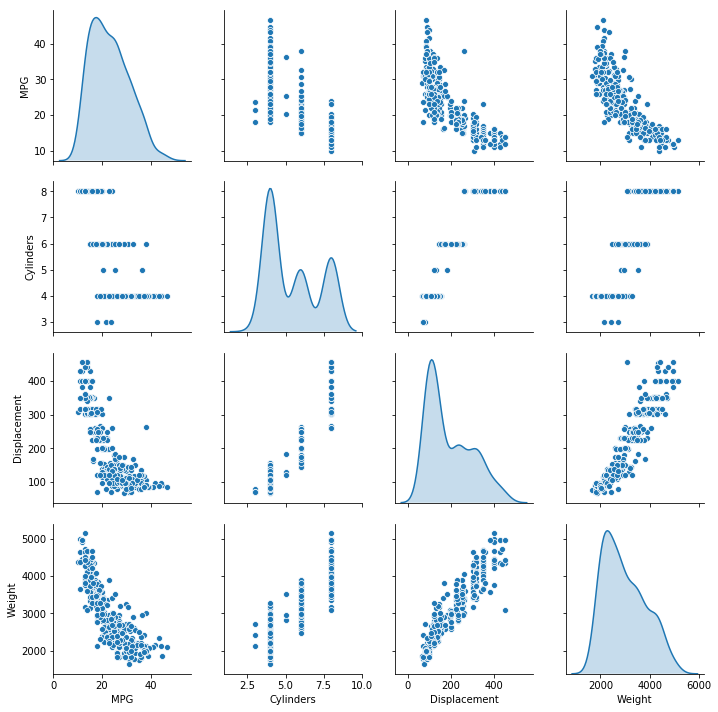

In [11]:
# sns를 이용하여 산점도 행렬 생성
## kde : kernel density estimates 형식으로 plot을 보여준다는 의미 
## 훈련데이터셋의 몇개의 열을 선택해 만듬 
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [12]:
# 전반적인 통계 확인 

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [13]:
# 특성과 레이블 분리하기 

## 특성에서 타깃값 또는 레이블을 분리한다
## 이 레이블을 예측하기 위해 모델을 훈련시킬 것 (모든 특성이 레이블이 될수있다)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [14]:
# 데이터 정규화 
## 특성의 트케일과 범위가 다르면 정규화 하는 것이 권장된다. 
## 특성을 정규화하지 않아도 모델이 수렴할 수 있지만 훈련시키기 어렵고 입력단위에 의존적인 모델이 만들어진다


def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# 이렇게 정규화된 데이터를 사용해 모델을 훈련한다 

# 주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 
    # 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 
    # 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.

In [ ]:
# 모델

In [15]:
# 모델 만들기

## 2개의 완전 연결 은닉층으로 sequential 모델을 만든다 
## 출력층은 하나의 연속적인 값을 반환한다. 
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[9]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [16]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
# 모델 확인 

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 모델 실행시키기

## 훈련세트에서 10 샘플을 하나의 배치로 만듬 
## 배치파일을 model.predict 메서드로 호출
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.07115605],
       [ 0.10674241],
       [-0.06104518],
       [-0.06654505],
       [-0.29305875],
       [ 0.03454995],
       [-0.30464554],
       [ 0.33479446],
       [-0.11170148],
       [-0.4257931 ]], dtype=float32)

In [ ]:
# 모델 훈련

In [19]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# 1000번 에포크 한다 
EPOCHS = 1000

# 검증 정확도가 저장되는 객체 - history 
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [21]:
# history 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.234461,0.979084,2.234461,9.837131,2.376025,9.837132,995
996,2.449665,1.025566,2.449665,9.832823,2.367176,9.832824,996
997,2.189496,0.950018,2.189495,9.734728,2.353567,9.734729,997
998,2.195899,0.937467,2.195899,9.502434,2.387918,9.502434,998
999,2.234194,0.973711,2.234194,9.624950,2.393213,9.624950,999


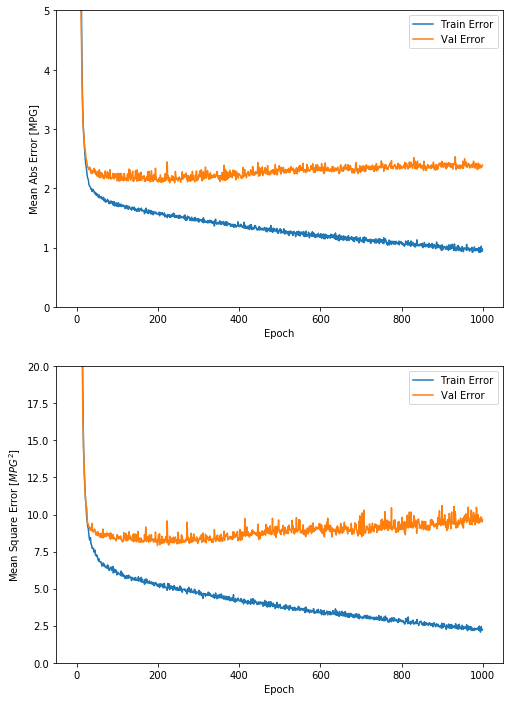

In [22]:
# history 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화

import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure(figsize=(8,12))
  
  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


## 그래프를 확인해보면 수백번 에포크를 진행한 후에는 모델이 거의 향상되지 않는 것 같이 보임



.................................................

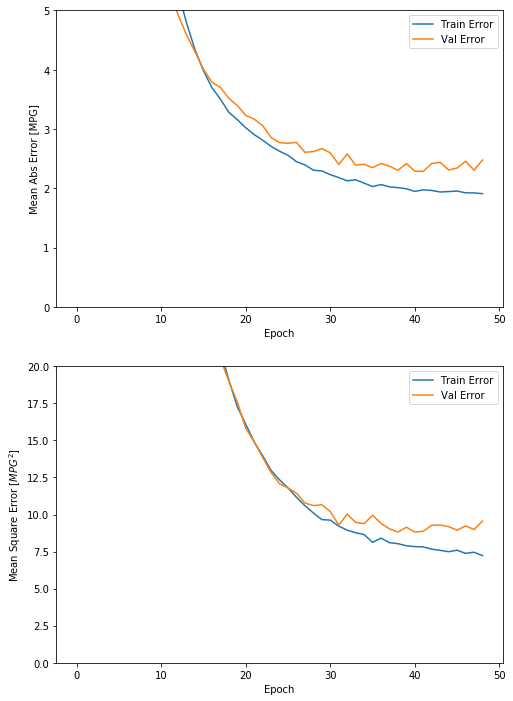

In [23]:
# 위에서 수백번 에포크를 진행한 후에는 모델이 거의 향상되지 않는 것 같이 보이기 때문에
# model.fit 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어봄 

model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 에포크마다 훈련상태를 점검하기 위해 earlystopping 콜백을 사용 - 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춤 
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [24]:
# 훈련할 때 사용하지 않았던 test set을 사용해서 모델의 성능테스트 

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

테스트 세트의 평균 절대 오차:  1.91 MPG


In [ ]:
# 예측 

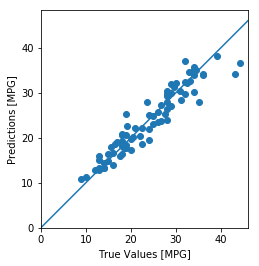

In [25]:
# 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

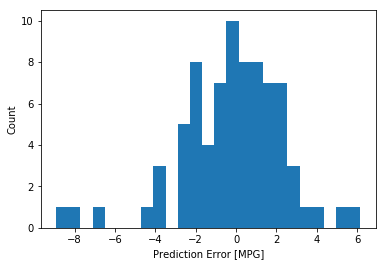

In [26]:
# 오차의 분포 확인 

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# 가우시안 분포가 아니지만 아마도 훈련 샘플의 수가 매우 작기 때문

In [ ]:
# 결론 

In [ ]:
# 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다(분류 문제에서 사용하는 손실 함수와 다름)
# 회귀에서 사용되는 평가 지표도 분류와 다름. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)
# 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 함
# 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋음
    ## 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법